In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
# %load ames_feat_transform.py
def trans_features(df):
    
    # drop irrelevant features
    drop_list = pd.read_excel('data/old_features_ames.xlsx', usecols="A,D").dropna()['Feature'].tolist()
    df.drop(columns=drop_list, inplace=True)
    
    
    # fill missing values
    ofdf = pd.read_excel('data/old_features_ames.xlsx', usecols="A,F")
    ofdf = ofdf[~ofdf['Feature'].isin(drop_list)]
    ofdf.dropna(inplace=True) #only target 'SalePrice' has NaN for 'Missing Handle'
    median_list = ofdf[ofdf['Missing Handle']=='median']['Feature'].tolist()
    mode_list = ofdf[ofdf['Missing Handle']=='mode']['Feature'].tolist()
    
    for med in median_list:
        df[med].fillna(df[med].median(), inplace=True)
    
    for mod in mode_list:
        df[mod].fillna(df[mod].mode()[0], inplace=True)
    
    cusdf = pd.read_excel('data/old_features_ames.xlsx', usecols="A,G")
    cusdf.dropna(inplace=True)
    for index, row in cusdf.iterrows():
        df[row['Feature']].fillna(row['Missing Custom'], inplace=True)
    
    
    # new features, all features all created before transformation.
    
    return df

In [4]:
df = trans_features(df)

In [9]:
df['Remodelling'] = df['YearRemodAdd'] - df['YearBuilt']

In [11]:
df['Remodelling'] = df['Remodelling'].apply(lambda x: 0 if x==0 else 1)

In [17]:
#df['LotAvailable'] = df['LotArea'].apply(lambda x: 0 if x==0 else 1)
df['UnfifnishedBasement'] = df['BsmtUnfSF'].apply(lambda x: 0 if x==0 else 1)
df['BsmtUnfRatio'] = df['BsmtUnfSF'] / df['TotalBsmtSF'].apply(lambda x: x+1)
df['SecondFloor'] = df['2ndFlrSF'].apply(lambda x: 0 if x==0 else 1)
df['TotalFullBath'] = df['BsmtFullBath'] + df['FullBath']
df['TotalHalfBath'] = df['BsmtHalfBath'] + df['HalfBath']
df['OtherRmsAbvGrd'] = df['TotRmsAbvGrd'] - df['BedroomAbvGr']

In [18]:
df['TotalFullBath'].value_counts()

2    750
1    371
3    319
4     18
6      1
0      1
Name: TotalFullBath, dtype: int64

In [19]:
df['TotalHalfBath'].value_counts()

0    855
1    572
2     29
3      3
4      1
Name: TotalHalfBath, dtype: int64

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


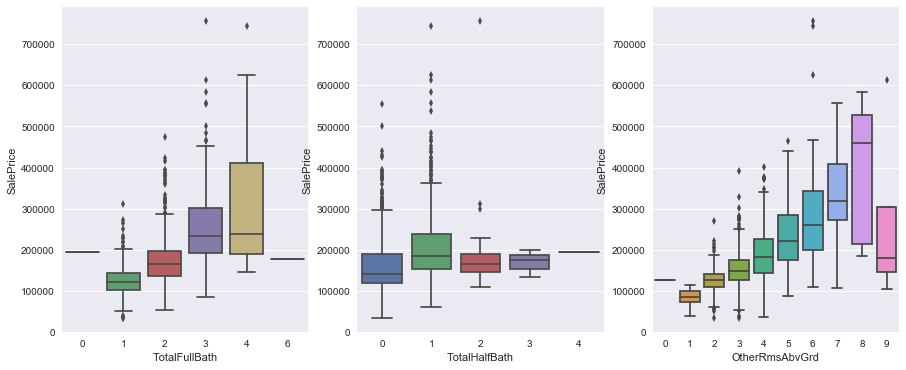

In [21]:
temp_list = ['TotalFullBath','TotalHalfBath','OtherRmsAbvGrd']

fig = plt.figure(figsize=(15,6))
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    sns.boxplot(df[temp_list[i-1]], df['SalePrice'], ax=ax)
    ax.set_xlabel(temp_list[i-1])

In [24]:
df['TotalFullBath'] = df['TotalFullBath'].apply(lambda x: 1 if x<1 else 4 if x>4 else x)

In [29]:
df['TotalHalfBath'] = df['TotalHalfBath'].apply(lambda x: 0 if x==0 else 1)

In [30]:
df['OtherRmsAbvGrd'].value_counts()

3    502
4    443
2    217
5    186
6     64
7     26
8     10
1      7
9      4
0      1
Name: OtherRmsAbvGrd, dtype: int64

In [33]:
df['OtherRmsAbvGrd'] = df['OtherRmsAbvGrd'].apply(lambda x: 1 if x<1 else 8 if x>8 else x)

In [34]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [35]:
def anova_result(feat, target, df):
    df_lm = ols(target + ' ~ ' + feat, data=df).fit()
    result = sm.stats.anova_lm(df_lm, typ=2) # return result in dataframe
    return result.loc[feat,'PR(>F)']

In [42]:
new_cat_list = ['Remodelling','UnfifnishedBasement','SecondFloor']
for feat in new_cat_list:
    result = anova_result(feat, 'SalePrice', df)
    print(feat + ": " + str(result))

Remodelling: 0.4023529235376785
UnfifnishedBasement: 2.675247686525976e-10
SecondFloor: 1.2885477358274021e-07


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


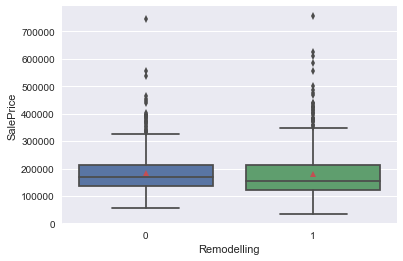

In [48]:
sns.boxplot(df['Remodelling'], df['SalePrice'], showmeans=True)

Drop Remodelling

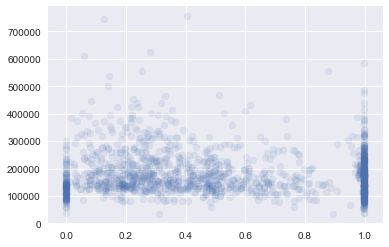

In [50]:
plt.scatter(df['BsmtUnfRatio'], df['SalePrice'], alpha=0.1)

Drop BsmtUnfRatio